In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
folder_path = 'drive/MyDrive/brain_tumor_dataset'
images = []
labels = []

# Prođi kroz sve datoteke u folderu
for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    if os.path.isdir(class_folder):
        # Prođi kroz sve slike u trenutnom podfolderu
        for filename in os.listdir(class_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_folder, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    labels.append(class_name)  # Dodaj ime podfoldera kao labelu
                else:
                    print(f'Failed to load image: {filename}')

In [ ]:
def plot_images(images, titles = None, columns = 5, figsize = (15, 15)):
    rows = len(images) // columns + 1
    plt.figure(figsize = figsize)
    for i in range(len(images)):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i], cmap = 'gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

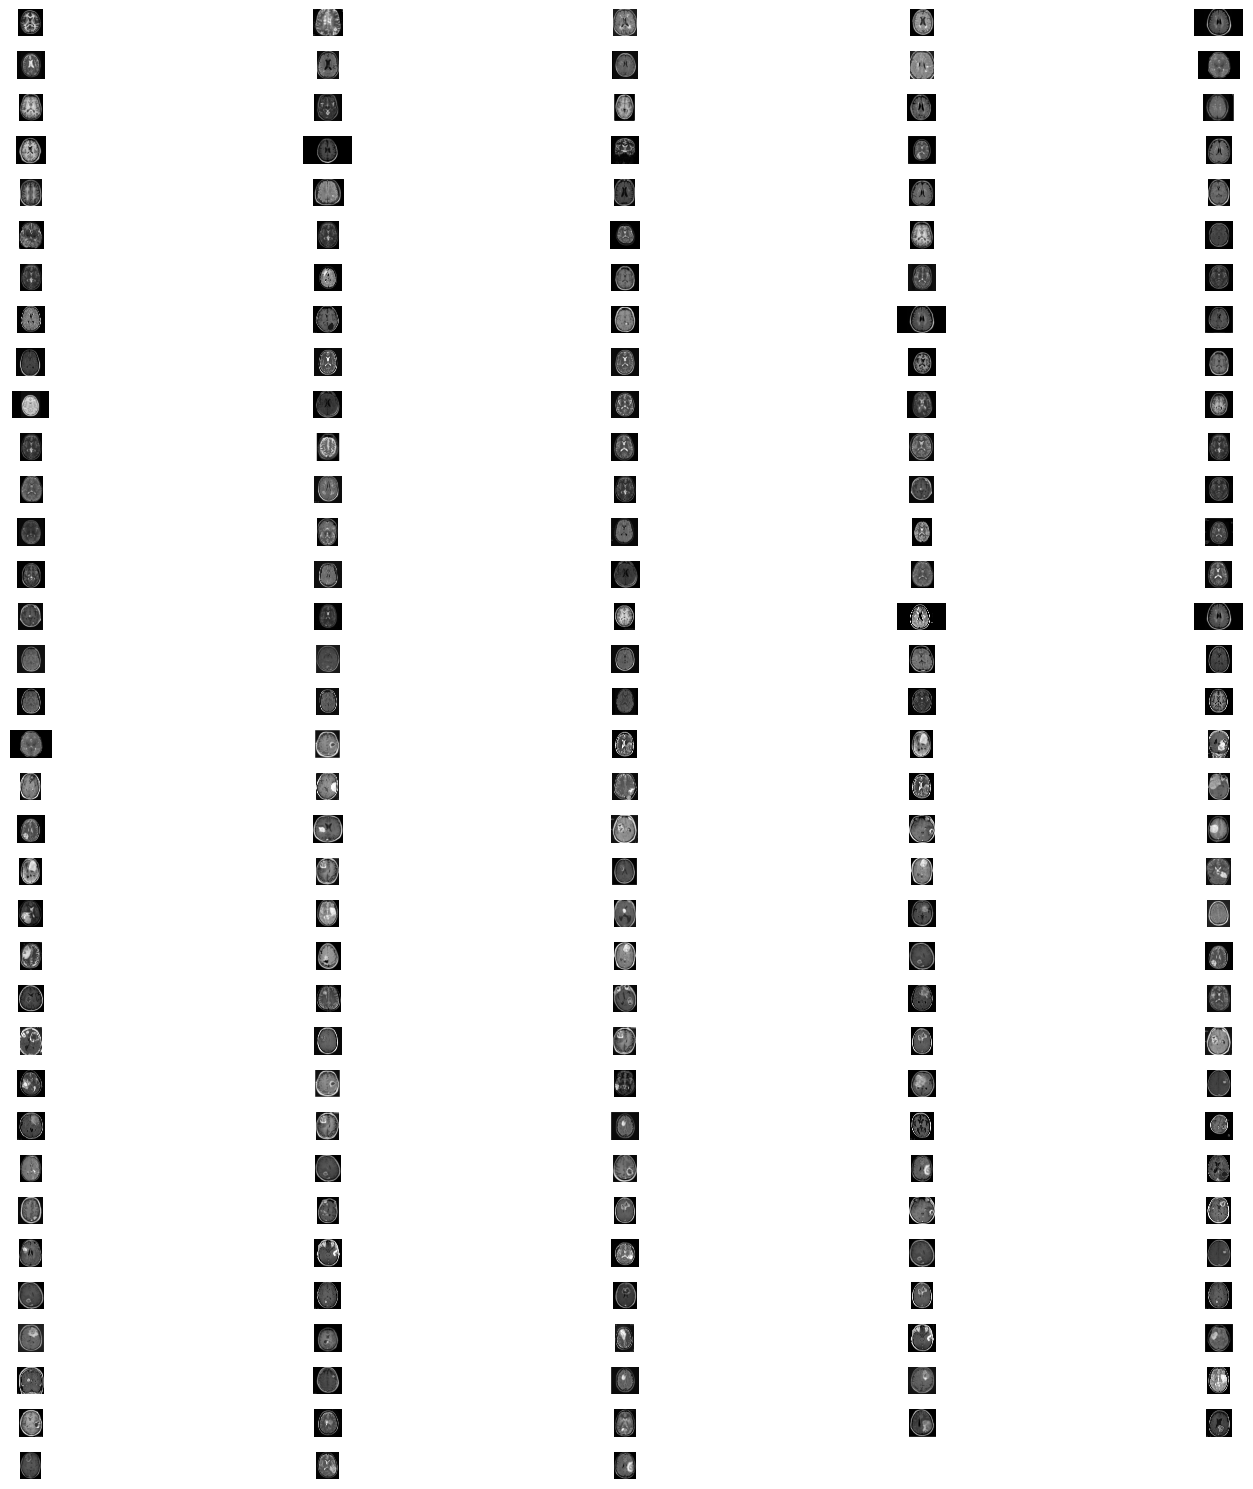

In [ ]:
plot_images(images)

In [ ]:
def calculate_snr(image):
    image = image.astype(np.float32)

    # Izračunavanje srednje vrednosti piksela (Signal)
    signal = np.mean(image)

    # Izračunavanje standardne devijacije piksela (Noise)
    noise = np.std(image)

    # Izračunavanje SNR
    snr = signal / noise

    return snr

In [ ]:
noises = []

for image in images:
    noise = calculate_snr(image)
    noises.append(noise)

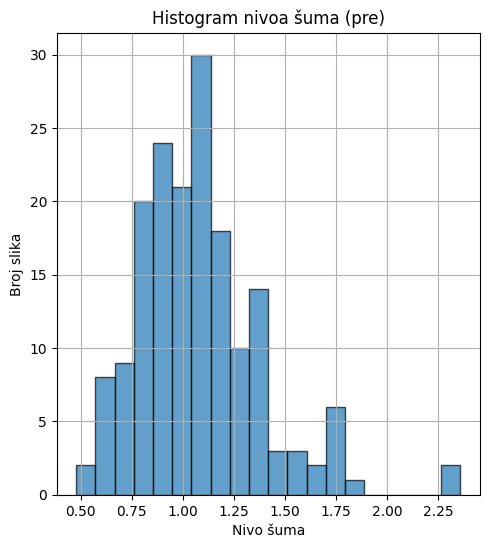

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(noises, bins = 20, edgecolor='k', alpha=0.7)
plt.xlabel('Nivo šuma')
plt.ylabel('Broj slika')
plt.title('Histogram nivoa šuma (pre)')
plt.grid(True)

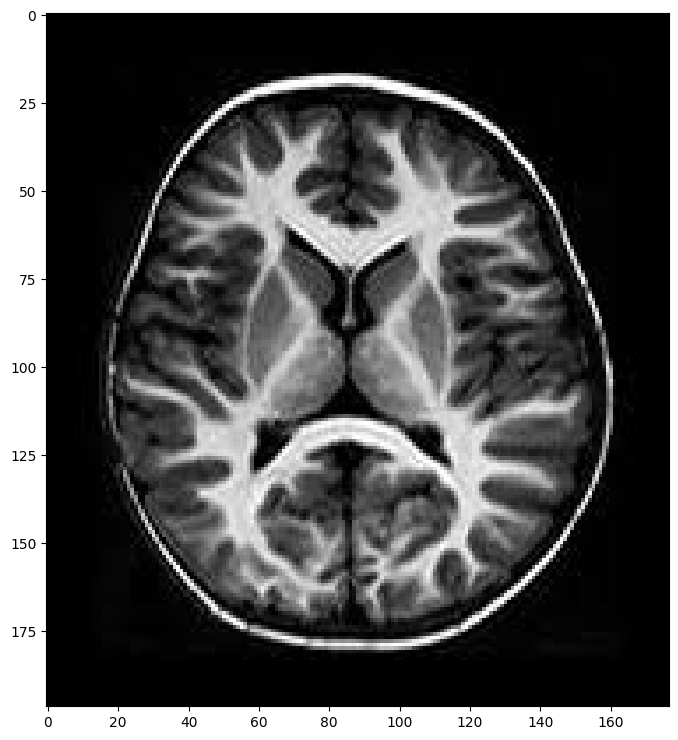

In [ ]:
plt.figure(figsize = (18,9))
plt.imshow(images[0], cmap = 'gray')

In [ ]:
def remove_noise_bilateral(image, filter_size = 30, sigma_color = 75, sigma_space = 75):
    return cv2.bilateralFilter(image, filter_size, sigma_color, sigma_space)

In [ ]:
def improve_image_quality(image, snr_threshold = 1, filter_size = 3):
    snr = calculate_snr(image)
    if snr < snr_threshold:
        improved_image = remove_noise_bilateral(image)
    else:
        improved_image = image

    return improved_image

In [ ]:
def interpolation(image):
    new_width = 900
    new_height = 500

    resized_image = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_CUBIC)

    return resized_image

In [ ]:
def kmeans_clustering(image, k = 7):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((image.shape))

    return segmented_image

In [ ]:
resised_images = []

for image in images:
    resised_image = np.copy(image)
    resised_image = interpolation(resised_image)
    resised_images.append(resised_image)

resised_images = np.array(resised_images)


In [ ]:
resised_images.shape

(173, 500, 900)

In [ ]:
improved_images = []

for image in resised_images:
    improved_image = np.copy(image)
    improved_image = improve_image_quality(improved_image)
    improved_images.append(improved_image)

improved_images = np.array(improved_images)

In [ ]:
noise_levels = [calculate_snr(i) for i in improved_images]

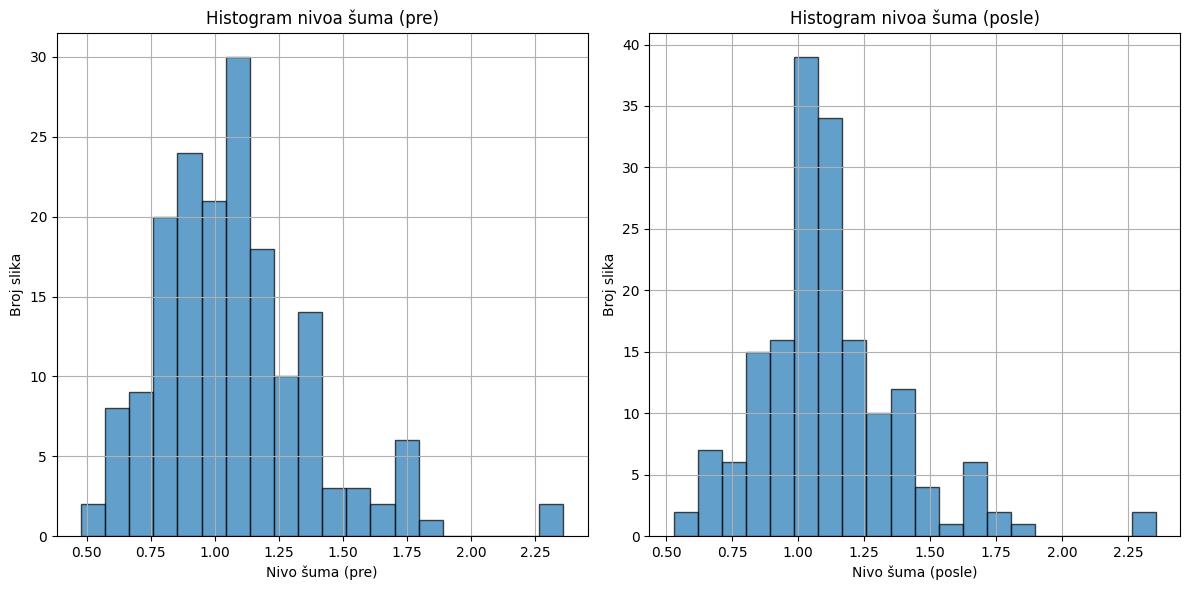

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(noises, bins = 20, edgecolor='k', alpha=0.7)
plt.xlabel('Nivo šuma (pre)')
plt.ylabel('Broj slika')
plt.title('Histogram nivoa šuma (pre)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(noise_levels, bins = 20, edgecolor='k', alpha=0.7)
plt.xlabel('Nivo šuma (posle)')
plt.ylabel('Broj slika')
plt.title('Histogram nivoa šuma (posle)')
plt.grid(True)

plt.tight_layout()
plt.show()

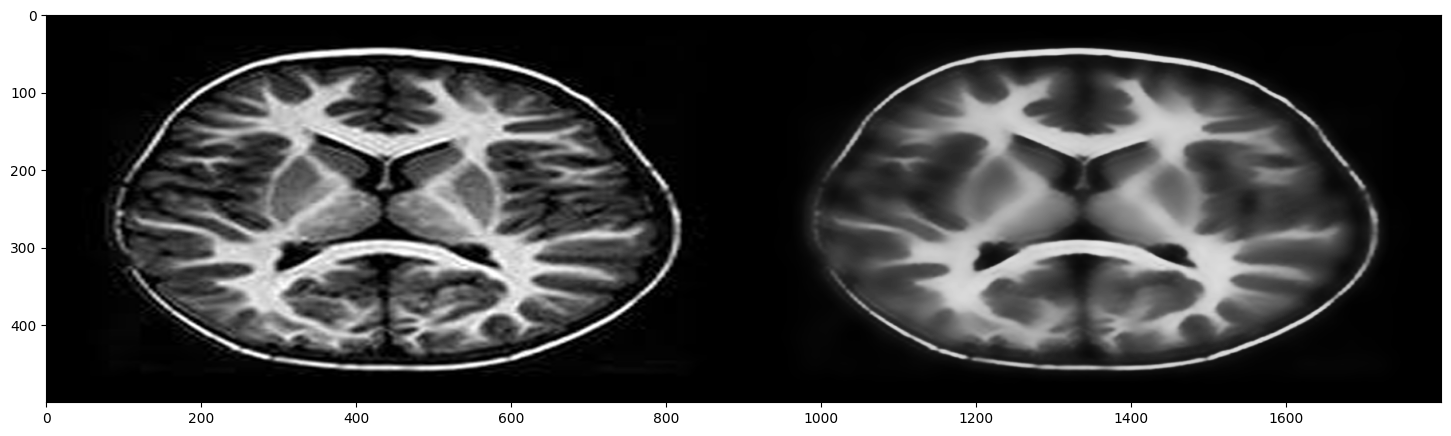

In [ ]:
plt.figure(figsize = (18,9))
compared = np.concatenate([resised_images[0], improved_images[0]], axis = 1)
plt.imshow(compared, cmap = 'gray')

In [ ]:
processed_images = []

for image in improved_images:
    processed_image = np.copy(image)
    processed_image = kmeans_clustering(processed_image)
    processed_images.append(processed_image)

processed_images = np.array(processed_images)

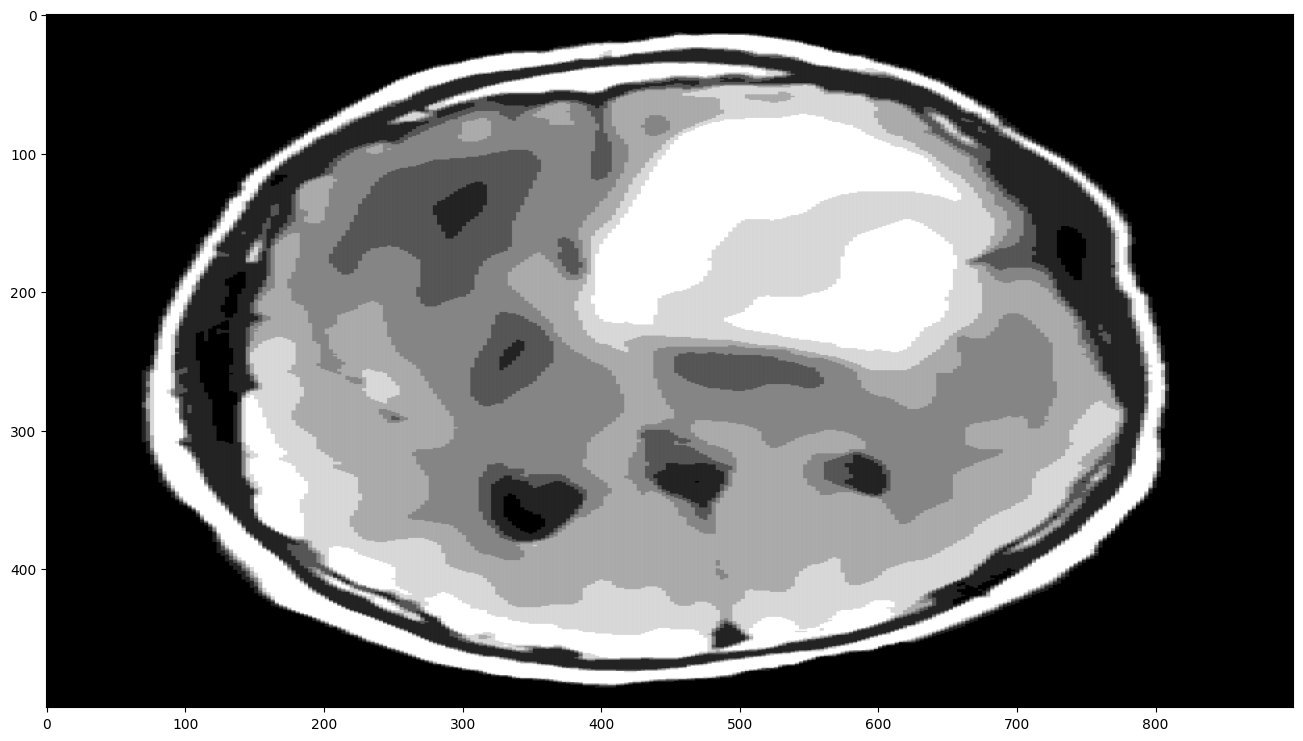

In [ ]:
plt.figure(figsize = (18,9))
plt.imshow(processed_images[100], cmap = 'gray')

In [ ]:
class_to_numeric = {"yes": 1, "no": 0}

In [ ]:
numeric_labels = []

In [ ]:
for label in labels:
    numeric_labels.append(class_to_numeric[label])

numeric_labels = np.array(numeric_labels)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (500, 900, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
X = processed_images

In [ ]:
y = numeric_labels

In [ ]:
X = X / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
model.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
5/5 [==============================] - 195s 35s/step - loss: 1.6866 - accuracy: 0.5580
Epoch 2/15
5/5 [==============================] - 181s 35s/step - loss: 0.6489 - accuracy: 0.6014
Epoch 3/15
5/5 [==============================] - 184s 36s/step - loss: 0.5695 - accuracy: 0.7319
Epoch 4/15
5/5 [==============================] - 184s 35s/step - loss: 0.4919 - accuracy: 0.7899
Epoch 5/15
5/5 [==============================] - 182s 35s/step - loss: 0.4491 - accuracy: 0.7681
Epoch 6/15
5/5 [==============================] - 181s 35s/step - loss: 0.3975 - accuracy: 0.7899
Epoch 7/15
5/5 [==============================] - 182s 35s/step - loss: 0.3414 - accuracy: 0.8768
Epoch 8/15
5/5 [==============================] - 179s 34s/step - loss: 0.3211 - accuracy: 0.8478
Epoch 9/15
5/5 [==============================] - 181s 35s/step - loss: 0.2211 - accuracy: 0.8913
Epoch 10/15
5/5 [==============================] - 179s 35s/step - loss: 0.1628 - accuracy: 0.9565
Epoch 11/15
5/5 [==

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 1)
print('Test accuracy:', test_acc)

2/2 [==============================] - 13s 1s/step - loss: 1.9362 - accuracy: 0.8857
Test accuracy: 0.8857142925262451
